<a href="https://colab.research.google.com/github/SreekarBasa/Art_Generatioin_NST/blob/main/Neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import numpy as np
import cv2 as cv
import tensorflow as tf
import tensorflow.keras.layers as tfl
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow_hub as hub
import pprint
import scipy.io
import scipy.misc

In [53]:
tf.random.set_seed(272)
pp = pprint.PrettyPrinter(indent=4)       # Prettyprint
image_size = 400
vgg = tf.keras.applications.VGG19(include_top = False,  # Expecting a RGB image
                                  weights = 'imagenet')
vgg.trainable = False   #Using the pretrained model without changing it
pp.pprint(vgg)

In [54]:
for layer in vgg.layers:
    print(layer.name)

input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [55]:
def compute_content_cost(content_output, generated_output):

    tensor_content = content_output[-1]       # Activations of hidden layers
    tensor_generated = generated_output[-1]
    # Dimensions
    _, n_h, n_w, n_c = tensor_generated.get_shape().as_list()

    # Reshaping into matrices
    reshape_content = tf.transpose(tf.reshape(tensor_content, shape=[1, n_h*n_w, n_c]))
    reshape_generated = tf.transpose(tf.reshape(tensor_generated, shape=[1, n_h*n_w, n_c]))

    # Formula of content cost function
    cost_content = (1/(4*n_h*n_w*n_c))*tf.reduce_sum(tf.square(tf.subtract(reshape_content,reshape_generated)))

    return cost_content

In [56]:
def gram_matrix(M):

    Gram_M = tf.matmul(M, tf.transpose(M))
    return Gram_M

In [57]:
def compute_layer_stylecost(tensor_style, tensor_generated):

    #dimensions
    _,n_h,n_w,n_c = tensor_generated.get_shape().as_list()

    # Reshapinfg into matrices
    tensor_style = tf.transpose(tf.reshape(tensor_style, shape=[-1,n_c]))
    tensor_generated = tf.transpose(tf.reshape(tensor_generated, shape=[-1,n_c]))

    gram_style = gram_matrix(tensor_style)
    gram_generated = gram_matrix(tensor_generated)

    # Formula for a layer cost func. in style cost func.
    cost_stylelayer =(1/(2*n_h*n_w*n_c)**2)*tf.reduce_sum(tf.square(tf.subtract(gram_style,gram_generated)))
    return cost_stylelayer

In [58]:
Style_Layers = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2),
]

In [59]:
def compute_stylecost(style_image_output, generated_image_output, Style_Layers=Style_Layers):

    cost_style = 0

    tensor_style = style_image_output[:-1]
    tensor_generated = generated_image_output[:-1]

    for i, weight in zip(range(len(tensor_style)), Style_Layers):
        cost_stylelayer = compute_layer_stylecost(tensor_style[i], tensor_generated[i])
        cost_style += weight[1]*cost_stylelayer

    return cost_style


In [60]:
def total_cost(cost_content, cost_style, a=10, b=40):
    cost = a*cost_content + b*cost_style
    return cost

In [61]:
content_image = np.array(Image.open("/content/content_img1.jpg").resize((image_size, image_size)))    # resizing image to (400,400,3)
content_image = tf.constant(np.reshape(content_image, ((1,)+content_image.shape)))      # now to (1,400,400,3) tensor


(1, 400, 400, 3)


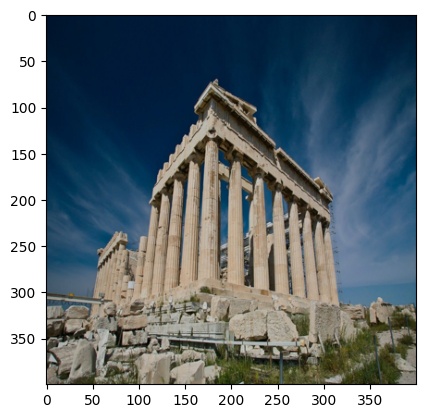

In [62]:
# Content Image
print(content_image.shape)
plt.imshow(content_image[0])
plt.show()

In [63]:
style_image = np.array(Image.open("/content/style_img2.jpg").resize((image_size, image_size)))    # resizing image to (400,400,3)
style_image = tf.constant(np.reshape(style_image, ((1,)+style_image.shape)))      # now to (1,400,400,3) tensor

(1, 400, 400, 3)


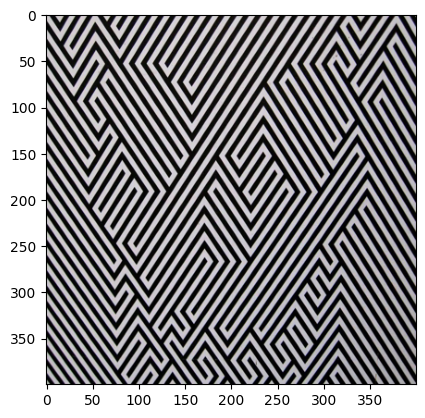

In [64]:
# style image -- resized version

print(style_image.shape)
plt.imshow(style_image[0])
plt.show()

In [65]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)    # min and max values of noise

# Adding the noise to generated image.... so that we start with that image
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

(1, 400, 400, 3)


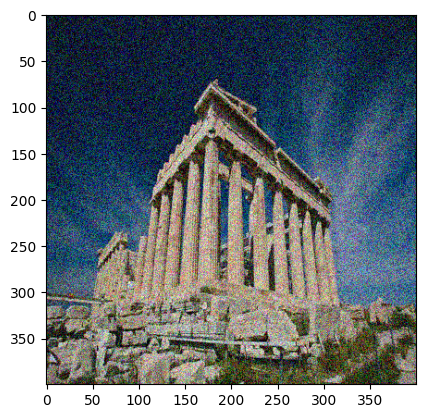

In [66]:
# Generated noisy image from content image
print(generated_image.shape)
plt.imshow(generated_image.numpy()[0])
plt.show()

In [67]:
def layer_outputs(vgg, layers_list):

    outputs = [vgg.get_layer(layer[0]).output for layer in layers_list]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [68]:
content_layer = [('block5_conv4', 1)]
vgg_model_outputs = layer_outputs(vgg, Style_Layers + content_layer)

content_target = vgg_model_outputs(content_image)
style_target = vgg_model_outputs(style_image)

In [69]:
content_image_tensor = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
style_image_tensor = tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))

tensor_content = vgg_model_outputs(content_image_tensor)
tensor_style = vgg_model_outputs(style_image_tensor)

In [70]:
def image_to_tensor(image):

  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):

  # As the pixel values are in between 0 and 1
  # They should get back to normal range of values

  tensor = (tensor) * 255
  tensor = np.array(tensor, dtype=np.uint8)
  # unit8 => 8 bit unsigned integer
  if np.ndim(tensor)>3:
      assert tensor.shape[0] == 1
      tensor = tensor[0]
  return Image.fromarray(tensor) # Returning image using PIL

In [71]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [72]:
def train_step(generated_image):
    with tf.GradientTape() as tape:

        tensor_generated = vgg_model_outputs(generated_image)

        # content_cost
        cost_content = compute_content_cost(tensor_content, tensor_generated)

        # style_cost
        cost_style = compute_stylecost(tensor_style, tensor_generated)

        # total_cost
        cost = total_cost(cost_content, cost_style)

    grad = tape.gradient(cost, generated_image) # To reocord progress

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(image_to_tensor(generated_image))

    return cost

In [73]:
generated_image = tf.Variable(generated_image)

Epoch - 0


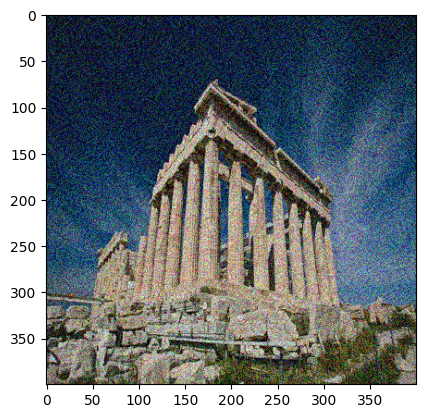

Epoch - 10


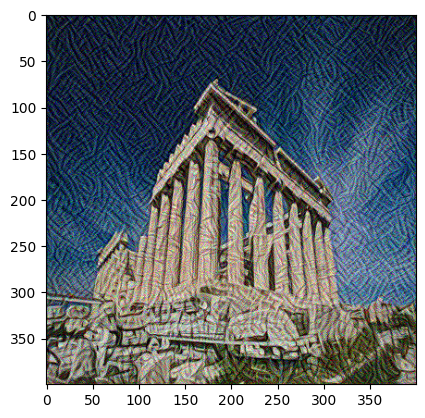

Epoch - 20


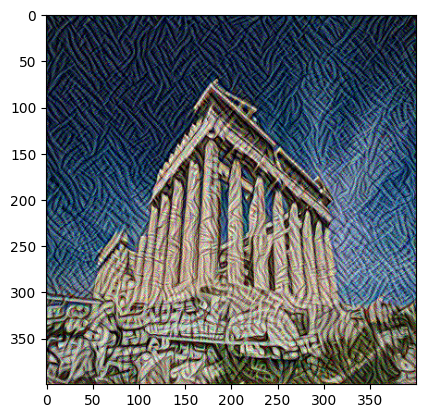

Epoch - 30


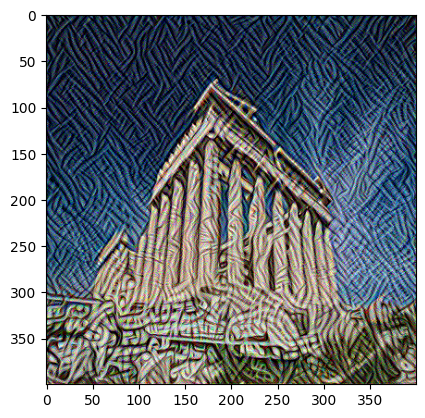

Epoch - 40


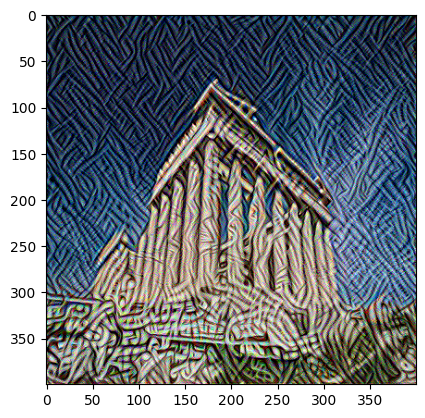

Epoch - 50


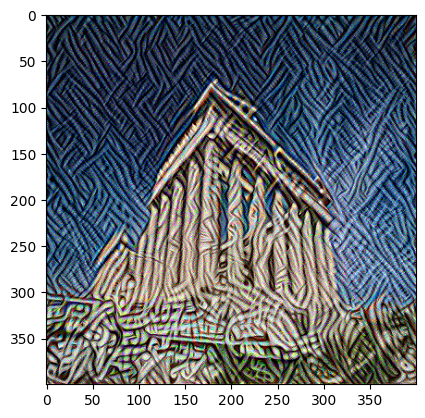

Epoch - 60


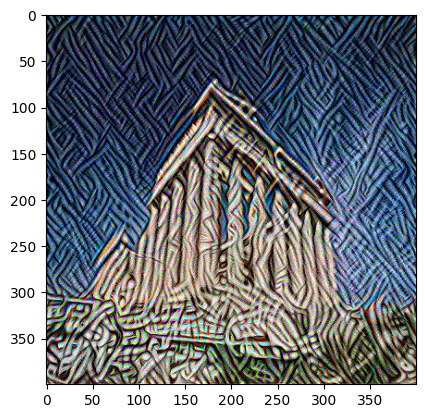

Epoch - 70


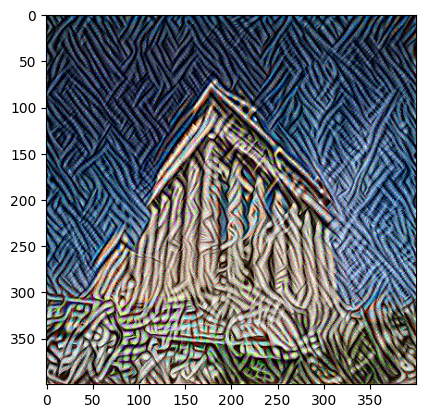

Epoch - 80


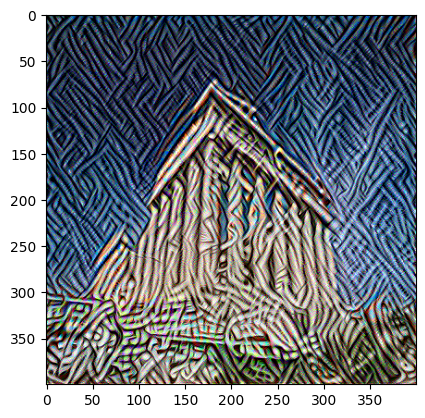

Epoch - 90


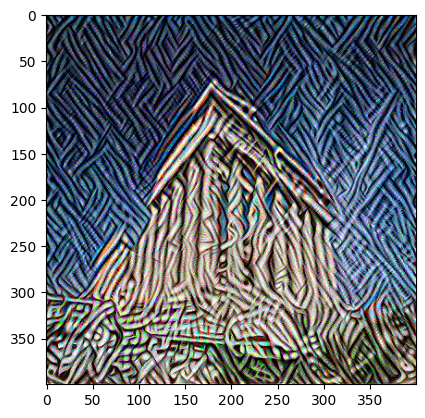

Epoch - 100


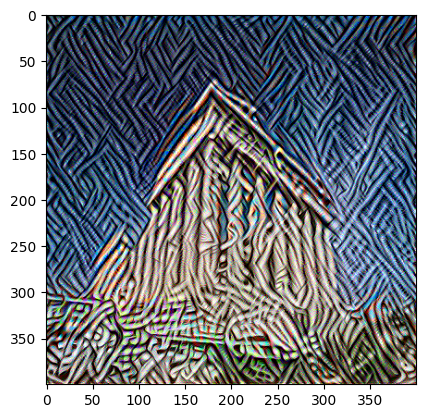

In [74]:
epochs = 101
for i in range(epochs):
    cost = train_step(generated_image)
    if i % 10 == 0:
      print(f"Epoch - {i}")  # printing epoch num
      image = tensor_to_image(generated_image)
      plt.imshow(image)                      # Intermidiate image results
      image.save(f"/content/generated_images1/gen_image_{i}.jpg")
      plt.show()


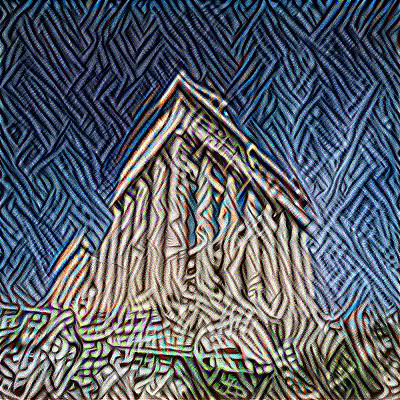

In [75]:
generated_img = Image.open('/content/generated_images1/gen_image_90.jpg')
generated_img